# Mini Project 2: Text classifiers

## Import external libraries and load external file into data frame

In [ ]:
import sys

force_re_run = True
on_colab = True
if on_colab:
    path_lib = '/content/drive/My Drive/Colab Notebooks/Mini Project 2 ECSE 551 Team 2/'
else:
    path_lib = './'

sys.path.append(path_lib)
sys.path.append(path_lib + 'Doing from scratch')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import warnings
from sklearn.utils import shuffle
from scipy import special
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import KFold
#from NB_scratch import MultinomialNB_scratch, BernoulliNB_scratch
from sklearn.naive_bayes import MultinomialNB, BernoulliNB

warnings.filterwarnings('ignore'),
np.set_printoptions(precision=4)

# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "sans-serif",
#     "font.sans-serif": ["Helvetica"]})

In [ ]:
pd.options.display.max_colwidth = 300

In [ ]:
example_file_path = 'https://raw.githubusercontent.com/rgmartin/ECSE551/main/reddit/ExampleSubmissionRandom.csv'
train_file_path = 'https://raw.githubusercontent.com/rgmartin/ECSE551/main/reddit/train.csv'
test_file_path = 'https://raw.githubusercontent.com/rgmartin/ECSE551/main/reddit/test.csv'

In [ ]:
accuracies_M_path = path_lib + 'aux_matrix/accuracies_M.csv'
accuracies_B_path = path_lib + 'aux_matrix/accuracies_B.csv'
accu_type_NB_path = path_lib + 'aux_matrix/accu_type_NB.png'

time_num_feature_M_path = path_lib + 'aux_matrix/time_M.csv'
time_num_feature_B_path = path_lib + 'aux_matrix/time_B.csv'
accuracies_num_feature_M_path = path_lib + 'aux_matrix/accuracies_num_feature_M.csv'
accuracies_num_feature_B_path = path_lib + 'aux_matrix/accuracies_num_feature_B.csv'
accuracies_num_feature_path = path_lib + 'aux_matrix/accuracies_num_feature.png'

In [ ]:
train = pd.read_csv(train_file_path, sep=',')
test = pd.read_csv(test_file_path, sep=',')
example = pd.read_csv(example_file_path, sep=',')

In [ ]:
X_train = train.body
y_train, target_labels = pd.factorize(train.subreddit)

In [ ]:
X_test = test.body

## Text processing

In [ ]:
from sklearn.feature_extraction import text

In [ ]:
my_stop_words = text.ENGLISH_STOP_WORDS

#### Clean text

In [ ]:
import re

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')


def text_prepare(text):
    """
    text: a string
        return: modified initial string
    """
    lower = text.lower()  # lowercase text
    space_replace = REPLACE_BY_SPACE_RE.sub(
        " ", lower)  #replace REPLACE_BY_SPACE_RE symbols by space in text
    nosymb = BAD_SYMBOLS_RE.sub(
        " ",
        space_replace)  # delete symbols which are in BAD_SYMBOLS_RE from text
    text = re.sub(r"\s*\b(?:{})\b".format("|".join(my_stop_words)), "",
                  nosymb)  # delete STOPWORDS

    return re.sub(r" {2,}", " ", text.strip())

In [ ]:
X_train = X_train.apply(text_prepare)
X_test = X_test.apply(text_prepare)

## Algorithms implementation

#### Result versus alpha

In [ ]:
#apply CountVectorizer to count number of occurences, which limits the maximum number of features to 5000
count = CountVectorizer(ngram_range=(1, 1), max_features=5000, binary=True)
X_train_for_NB = count.fit_transform(X_train).toarray()
X_test_for_NB = count.transform(X_test).toarray()

Implement Cross Validation using KFold

In [ ]:
num_k_folds = 5
alpha_range = np.logspace(-3, 0, 20)

In [ ]:
external_file_is_present = os.path.isfile(accuracies_M_path)
print(external_file_is_present)

True


In [ ]:
if force_re_run or not external_file_is_present:

    #create accuracy matrix
    accuracy_multinomial = np.zeros((num_k_folds, len(alpha_range)))
    accuracy_bernoulli = np.zeros((num_k_folds, len(alpha_range)))

    for ii, alpha in enumerate(alpha_range):
        #init model
        naiveBayesClf_mul = MultinomialNB_scratch(alpha)
        naiveBayesClf_ber = BernoulliNB_scratch(alpha, 0.5)

        kf = KFold(n_splits=num_k_folds, shuffle=True)

        ix = 0
        for train_index, test_index in kf.split(X_train_for_NB):

            xtrain, xtest = X_train_for_NB[train_index], X_train_for_NB[
                test_index]
            ytrain, ytest = y_train[train_index], y_train[test_index]

            #train and predict
            naiveBayesClf_mul.fit(xtrain, ytrain)
            naiveBayesClf_ber.fit(xtrain, ytrain)
            accuracy_multinomial[ix,
                                 ii] = naiveBayesClf_mul.score(xtest, ytest)
            accuracy_bernoulli[ix, ii] = naiveBayesClf_ber.score(xtest, ytest)

            print('.', end='', flush=True)
            ix += 1

In [ ]:
if force_re_run or not external_file_is_present:
    np.savetxt(accuracies_M_path, accuracy_multinomial, delimiter=',')
    np.savetxt(accuracies_B_path, accuracy_bernoulli, delimiter=',')
else:
    accuracy_multinomial = np.genfromtxt(accuracies_M_path, delimiter=',')
    accuracy_bernoulli = np.genfromtxt(accuracies_B_path, delimiter=',')

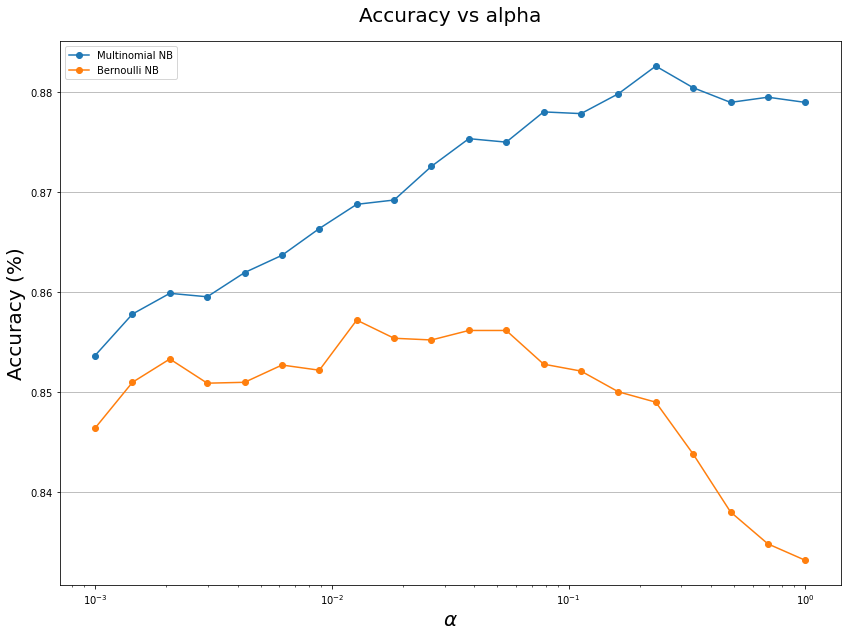

In [ ]:
fig, ax = plt.subplots(figsize=(14, 10))
plt.plot(alpha_range,
         np.mean(accuracy_multinomial, axis=0),
         'o-',
         label='Multinomial NB')
plt.plot(alpha_range,
         np.mean(accuracy_bernoulli, axis=0),
         'o-',
         label='Bernoulli NB')
plt.xscale('log')
plt.legend(loc="upper left")
ax.yaxis.grid(True, which='major')
ax.yaxis.grid(True, which='minor')
plt.ylabel('Accuracy (%)', fontsize=20)
plt.xlabel(r'$\alpha$', fontsize=20)
plt.title('Accuracy vs alpha', fontsize=20, pad=20)
plt.savefig(accu_type_NB_path)
plt.show()

#### Result versus number of features

In [ ]:
external_file_is_present = os.path.isfile(accuracies_num_feature_path)
print(external_file_is_present)

True


In [ ]:
num_feature_range = np.append(np.arange(3000, 20000, 2000), 40000)

In [ ]:
if force_re_run or not external_file_is_present:
    #create accuracy and time matrix
    time_multinomial = np.zeros((num_k_folds, len(num_feature_range)))
    time_bernoulli = np.zeros((num_k_folds, len(num_feature_range)))
    accuracy_multinomial = np.zeros((num_k_folds, len(num_feature_range)))
    accuracy_bernoulli = np.zeros((num_k_folds, len(num_feature_range)))

    for ii, num_feature in enumerate(num_feature_range):

        #apply CountVectorizer
        count = CountVectorizer(ngram_range=(1, 1),
                                max_features=num_feature,
                                binary=True)
        X_train_for_NB = count.fit_transform(X_train).toarray()
        X_test_for_NB = count.transform(X_test).toarray()

        #define number of folds and alpha
        num_k_folds = 5
        alpha = 0.1

        #init model
        naiveBayesClf_mul = MultinomialNB_scratch(alpha)
        naiveBayesClf_ber = BernoulliNB_scratch(alpha, 0.5)

        kf = KFold(n_splits=num_k_folds, shuffle=True)

        ix = 0
        for train_index, test_index in kf.split(X_train_for_NB):
            xtrain, xtest = X_train_for_NB[train_index], X_train_for_NB[
                test_index]
            ytrain, ytest = y_train[train_index], y_train[test_index]

            #train and predict
            start_time_mul = time.time()
            naiveBayesClf_mul.fit(xtrain, ytrain)
            accuracy_multinomial[ix,
                                 ii] = naiveBayesClf_mul.score(xtest, ytest)
            time_multinomial[ix, ii] = (time.time() - start_time_mul)

            start_time_ber = time.time()
            naiveBayesClf_ber.fit(xtrain, ytrain)
            accuracy_bernoulli[ix, ii] = naiveBayesClf_ber.score(xtest, ytest)
            time_bernoulli[ix, ii] = (time.time() - start_time_ber)

            print('.', end='', flush=True)
            ix += 1

In [ ]:
if force_re_run or not external_file_is_present:
    np.savetxt(accuracies_num_feature_M_path,
               accuracy_multinomial,
               delimiter=',')
    np.savetxt(accuracies_num_feature_B_path,
               accuracy_bernoulli,
               delimiter=',')

    np.savetxt(time_num_feature_M_path, time_multinomial, delimiter=',')
    np.savetxt(time_num_feature_B_path, time_bernoulli, delimiter=',')

else:
    accuracy_multinomial = np.genfromtxt(accuracies_num_feature_M_path,
                                         delimiter=',')
    accuracy_bernoulli = np.genfromtxt(accuracies_num_feature_B_path,
                                       delimiter=',')

    time_multinomial = np.genfromtxt(time_num_feature_M_path, delimiter=',')
    time_bernoulli = np.genfromtxt(time_num_feature_B_path, delimiter=',')

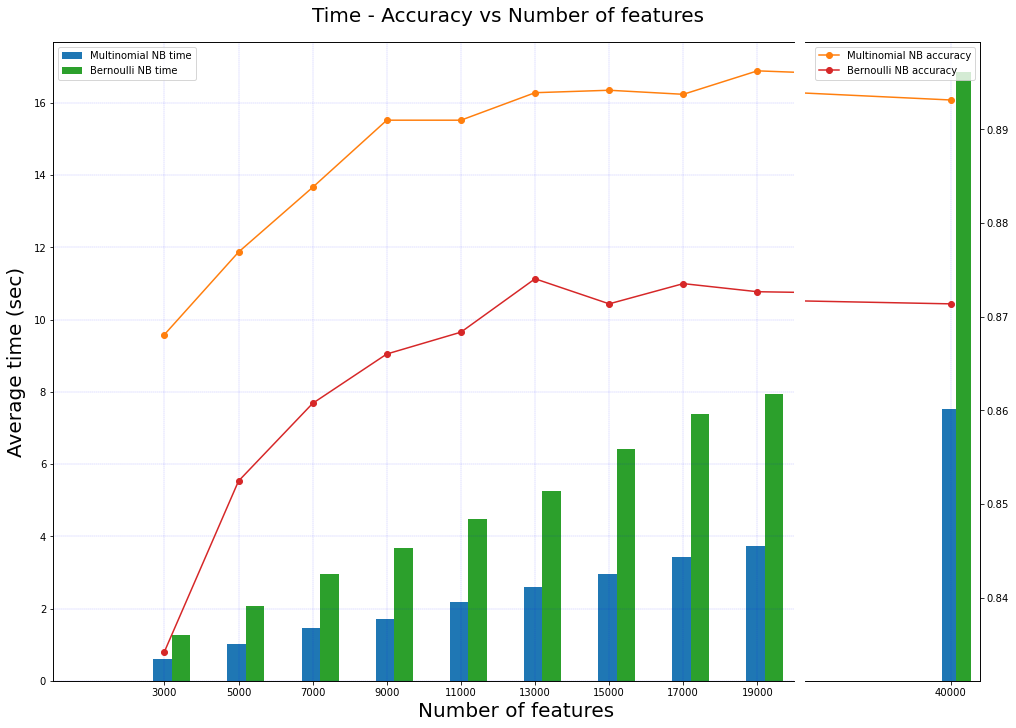

In [ ]:
width = 500  # the width of the bars

fig = plt.figure(constrained_layout=True, figsize=(14, 10))
gs = fig.add_gridspec(1, 5)

ax_all = fig.add_subplot(gs[:, :])
ax_all.spines['top'].set_color('none')
ax_all.spines['bottom'].set_color('none')
ax_all.spines['left'].set_color('none')
ax_all.spines['right'].set_color('none')
ax_all.tick_params(labelcolor='w',
                   top=False,
                   bottom=False,
                   left=False,
                   right=False)

ax1 = fig.add_subplot(gs[0, 0:4])
ax1.bar(num_feature_range - width / 2 + 200,
        np.mean(time_multinomial, axis=0),
        width,
        color='C0',
        label='Multinomial NB time')
ax1.bar(num_feature_range + width / 2 + 200,
        np.mean(time_bernoulli, axis=0),
        width,
        color='C2',
        label='Bernoulli NB time')
ax1.set_xticks(num_feature_range)
ax1.legend(loc="upper left")
ax1.grid(color='b', ls=':', lw=0.25)

ax1_2 = ax1.twinx()
ax1_2.plot(num_feature_range,
           np.mean(accuracy_multinomial, axis=0),
           'o-',
           color='C1',
           label='Multinomial NB accuracy')
ax1_2.plot(num_feature_range,
           np.mean(accuracy_bernoulli, axis=0),
           'o-',
           color='C3',
           label='Bernoulli NB accuracy')

# for a, b in zip(num_feature_range, np.mean(accuracy_multinomial, axis=0)):
#     ax1_2.text(a, b + 0.005, str(b)[0:5])
# for a, b in zip(num_feature_range, np.mean(accuracy_bernoulli, axis=0)):
#     ax1_2.text(a, b + 0.005, str(b)[0:5])

ax2 = fig.add_subplot(gs[0, 4])
ax2.bar(num_feature_range - width / 2 + 200,
        np.mean(time_multinomial, axis=0),
        width,
        color='C0',
        label='Multinomial NB time')
ax2.bar(num_feature_range + width / 2 + 200,
        np.mean(time_bernoulli, axis=0),
        width,
        color='C2',
        label='Bernoulli NB time')
ax2.set_xticks(num_feature_range)
ax2.grid(color='b', ls=':', lw=0.25)

ax1.set_xlim(0, 20000)  # outliers only
ax2.set_xlim(35000, 41000)  # most of the data

ax2_2 = ax2.twinx()
ax2_2.plot(num_feature_range,
           np.mean(accuracy_multinomial, axis=0),
           'o-',
           color='C1',
           label='Multinomial NB accuracy')
ax2_2.plot(num_feature_range,
           np.mean(accuracy_bernoulli, axis=0),
           'o-',
           color='C3',
           label='Bernoulli NB accuracy')
ax2_2.legend(loc="upper right")

ax_all.set_ylabel('Average time (sec)', fontsize=20)
ax_all.set_xlabel('Number of features', fontsize=20)

# hide the spines between ax and ax2
ax1.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax1.yaxis.tick_left()
ax2.yaxis.set_ticks([])

ax1_2.spines['right'].set_visible(False)
ax2_2.spines['left'].set_visible(False)
ax2_2.yaxis.tick_right()
ax1_2.yaxis.set_ticks([])

plt.suptitle('Time - Accuracy vs Number of features', fontsize=20)
# plt.legend(loc="upper right")
plt.savefig(accuracies_num_feature_path)
plt.show()

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import Normalizer

In [ ]:
text_clf_logreg = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1, 1))),
    #('norm',Normalizer(copy = 'False')),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression(n_jobs=-1, C=25)),
])

In [ ]:
text_clf_logreg.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(C=25, n_jobs=-1))])

In [ ]:
np.mean(cross_val_score(text_clf_logreg, X_train, y_train, verbose=10))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] .................................... , score=0.901, total=   4.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s remaining:    0.0s


[CV] .................................... , score=0.904, total=   4.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.7s remaining:    0.0s


[CV] .................................... , score=0.901, total=   4.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   14.4s remaining:    0.0s


[CV] .................................... , score=0.899, total=   4.4s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   18.8s remaining:    0.0s


[CV] .................................... , score=0.903, total=   4.7s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   23.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   23.5s finished


0.9013122203313646

Creation of submission csv

In [ ]:
submission = test.copy()
prediction = text_clf_logreg.predict(X_test)
submission['subreddit'] = target_labels[prediction]

In [ ]:
submission = submission.drop(columns=['body'])
submission.to_csv('out.csv', index=False)

#### Auxiliary grid search

In [ ]:
parameters = {
    'vect__ngram_range': [(1, 1)],
    'tfidf__use_idf': [True],
    'clf__C': [25],
    'clf__penalty': ["l2"]
}
gs_clf_logreg = GridSearchCV(text_clf_logreg, parameters, cv=5, n_jobs=-1)

In [ ]:
gs_clf_logreg = gs_clf_logreg.fit(X_train, y_train)

In [ ]:
gs_clf_logreg.best_score_

0.9013122203313646

In [ ]:
gs_clf_logreg.best_params_

{'clf__C': 25,
 'clf__penalty': 'l2',
 'tfidf__use_idf': True,
 'vect__ngram_range': (1, 1)}

In [ ]:
means = gs_clf_logreg.cv_results_['mean_test_score']
stds = gs_clf_logreg.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, gs_clf_logreg.cv_results_['params']):
    print("%0.5f (+/-%0.03f) for %r" % (mean, std * 2, params))

0.90131 (+/-0.004) for {'clf__C': 25, 'clf__penalty': 'l2', 'tfidf__use_idf': True, 'vect__ngram_range': (1, 1)}


#### Grid search for logistic regression.. no need to run it again (takes a long time), I already put the best parameters on the above cell.

In [ ]:
if force_re_run:
    parameters = {
        'vect__ngram_range': [(1, 1), (1, 2)],
        'tfidf__use_idf': (True, False),
        'clf__C': np.logspace(-3, 3, 7),
        'clf__penalty': ["l1", "l2"]
    }
    gs_clf_logreg = GridSearchCV(text_clf_logreg, parameters, cv=5, n_jobs=-1)

In [ ]:
if force_re_run:
    gs_clf_logreg = gs_clf_logreg.fit(X_train, y_train)